In [1]:
from itertools import product
import multiprocessing

import pandas as pd
import seaborn as sns
import matplotlib as plt
import scipy.sparse as sp
import numpy as np

from fairpair import *

In [6]:
from accuracy_workers import *

In [ ]:
from GNN_workers import *

## Export Graphs

In [ ]:
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

In [ ]:
sampler = RandomSampling(G, warn=False)
ranker = RankRecovery(G)
path = './data/GNNRank_networks/'

for j in range(101):
    sampler.apply(iter=10, k=1)
    if nx.is_strongly_connected(G): # only apply ranking recovery if strongly connected
        adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
        nodes = np.array(G.nodes)
        sp.save_npz(f'{path}random_iter{j*10}_adj', adj)
        np.save(f'{path}random_iter{j*10}_node_list', nodes)

## Read Results

In [ ]:
path = './data/GNNRank_results/'
ranking = np.load(f'{path}DIGRACinnerproduct_pred0.npy')

In [ ]:
ranks = []
j = 500
for node, data in G.majority.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Privileged'))
for node, data in G.minority.nodes(data=True):
    ranks.append((j, data['skill'], data['bias'], data['score'], ranking[node], 'Unprivileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])

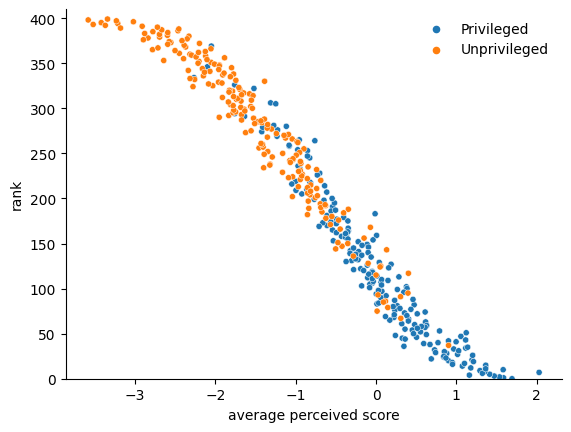

In [ ]:
data = ranks
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()

## Integrated Evaluation

In [ ]:
import torch

import sys
sys.path.append('../GNNRank/') # also add the path to Pylance in VSCode settings: python.analysis.extraPaths

from src.param_parser import ArgsNamespace # just import the class, not the parser
from src.Trainer import Trainer

In [ ]:
# Instead of parsing, set all arguments directly
# Carefully check if the settings are actually possible!
args = ArgsNamespace(AllTrain=True, ERO_style='uniform', F=70, Fiedler_layer_num=5, K=20, N=350, SavePred=False, all_methods=['DIGRAC', 'ib'],
                     alpha=1.0, baseline='syncRank', be_silent=False, cuda=True, data_path='/home/jovyan/GNNRank/src/../data/', dataset='fairPair_test/',
                     debug=False, device=torch.device(type='cuda'), dropout=0.5, early_stopping=200, epochs=1000, eta=0.1, fill_val=0.5, hidden=8, hop=2,
                     load_only=False, log_root='/home/jovyan/GNNRank/src/../logs/', lr=0.01, no_cuda=False, num_trials=1, optimizer='Adam', p=0.05,
                     pretrain_epochs=50, pretrain_with='dist', regenerate_data=True, season=1990, seed=31, seeds=[10], sigma=1.0, tau=0.5, test_ratio=1,
                     train_ratio=1, train_with='proximal_baseline', trainable_alpha=False, upset_margin=0.01, upset_margin_coeff=0, upset_ratio_coeff=1.0, weight_decay=0.0005)
torch.manual_seed(args.seed)

In [ ]:
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

In [ ]:
sampler = RandomSampling(G, warn=False)
sampler.apply(iter=40, k=1)
print('G is strongly connected.' if nx.is_strongly_connected(G) else 'G is NOT strongly connected!')
print(f'G has {G.number_of_nodes()} nodes and {len(G.edges)} edges.')

G is strongly connected.
G has 400 nodes and 3152 edges.


In [ ]:
adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
trainer = Trainer(args, random_seed=10, save_name_base='test', adj=adj) # initialize with the given adjacency matrix

Generating new data or new data splits!
loaded test_mask: None


In [ ]:
save_path_best, save_path_latest = trainer.train(model_name='ib')

  0%|          | 0/1000 [00:00<?, ?epochs/s]

Early stopped after 200 epochs without improvement.


In [ ]:
### Test modifying the network to investigate effects on generalizability

## Adding comparisons
#sampler.apply(iter=1000, k=1)
#print(f'G has {G.number_of_nodes()} nodes and {len(G.edges)} edges.')

## Dropping edges
#rng = np.random.default_rng()
#to_remove = rng.choice(G.edges, size=1000, replace=False)
#G.remove_edges_from(to_remove)
#print(f'Removed 40000 edges. G has now {G.number_of_nodes()} nodes and {len(G.edges)} edges.')

In [ ]:
#adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
# We load A while initializing a new Trainer instance
score, pred_label = trainer.predict_nn(model_name='ib', model_path=save_path_best, A=None, GNN_variant='proximal_baseline')
ranking = {key: 1-score[0] for key, score in enumerate(score.cpu().detach().numpy())}
ranking

{0: 0.5144670009613037,
 1: 0.5345504581928253,
 2: 0.5061275362968445,
 3: 0.5409384965896606,
 4: 0.49386847019195557,
 5: 0.5257960855960846,
 6: 0.46082282066345215,
 7: 0.5344527661800385,
 8: 0.517162412405014,
 9: 0.5285908281803131,
 10: 0.48855143785476685,
 11: 0.538844883441925,
 12: 0.4828869700431824,
 13: 0.5032058358192444,
 14: 0.5074435770511627,
 15: 0.525470644235611,
 16: 0.5505736768245697,
 17: 0.513301432132721,
 18: 0.47091519832611084,
 19: 0.480710506439209,
 20: 0.48365455865859985,
 21: 0.540238618850708,
 22: 0.5278501808643341,
 23: 0.49943113327026367,
 24: 0.4806326627731323,
 25: 0.5133569240570068,
 26: 0.5107673108577728,
 27: 0.4980122447013855,
 28: 0.5245898365974426,
 29: 0.4920641779899597,
 30: 0.5237485766410828,
 31: 0.48397594690322876,
 32: 0.5131720900535583,
 33: 0.482882022857666,
 34: 0.5474376082420349,
 35: 0.5111722648143768,
 36: 0.5138053894042969,
 37: 0.5097498893737793,
 38: 0.49211448431015015,
 39: 0.4763866066932678,
 40: 0.52

In [ ]:
weighted_tau(G, ranking, score_attr='score')

0.26336010686934586

In [ ]:
ranker = RankRecovery(G)
ranking2, other_nodes = ranker.apply()
weighted_tau(G, ranking2, score_attr='score')

0.2717231190150487

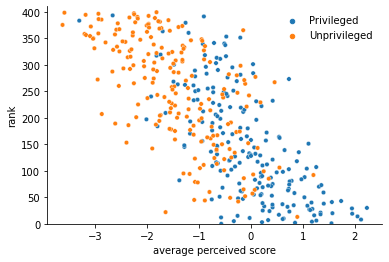

In [ ]:
ranks = []
j = 500

for node, data in G.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Unprivileged' if data['minority'] else 'Privileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])
data = ranks
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()

## Parallel GNNRank

In [ ]:
if __name__ == '__main__':
    multiprocessing.set_start_method('spawn')
    pool = multiprocessing.Pool(processes=10) # limit the num of processes in order to not overflow the GPU memory
    accuracy = pool.map(get_GNNRank_accuracy, range(10))
    accuracy = [result for pool in accuracy for result in pool]
    accuracy = pd.DataFrame(accuracy, columns=['trial', 'iteration', 'Weighted Kemeny distance', 'group'])

In [ ]:
accuracy.to_csv('./data/GNNRank_results/skill_accuracy_no_bias.csv', index=False)

In [ ]:
accuracy = pd.read_csv('./data/GNNRank_results/skill_accuracy.csv')

In [ ]:
tasks = list(product(range(10), [davidScore, rankCentrality]))

if __name__ == '__main__':
    pool = multiprocessing.Pool()
    accuracy2 = pool.starmap(get_method_accuracy, tasks)
    accuracy2 = [result for pool in accuracy2 for result in pool]
    accuracy2 = pd.DataFrame(accuracy2, columns=['trial', 'iteration', 'Weighted Kemeny distance', 'group', 'method'])

In [ ]:
accuracy['method'] = 'GNNRank'
data = pd.concat([accuracy, accuracy2])

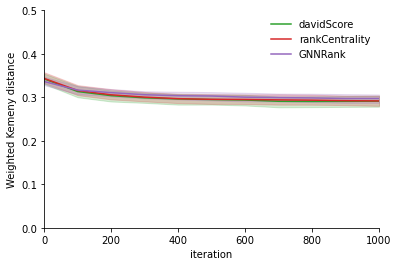

In [ ]:
palette = sns.color_palette()
palette[0] = palette[2]
palette[1] = palette[3]
palette[2] = palette[4]
with sns.color_palette(palette):
    ax = sns.lineplot(data, x='iteration', y='Weighted Kemeny distance', hue='method', hue_order=['davidScore', 'rankCentrality', 'GNNRank'])
ax.legend(title=None, frameon=False, prop={'size': 10})
ax.set(ylim=(0,0.5), xlim=(0,1000))
sns.despine()
ax.figure.savefig('accuracy_y5.png',dpi=600)

## Generalizability

In [ ]:
tasks = list(product(range(10), [100]))

if __name__ == '__main__':
    try: multiprocessing.set_start_method('spawn') # if it wasn't alrady set, make sure we use the `spawn` method.
    except RuntimeError: pass
    pool = multiprocessing.Pool(processes=10) # limit the num of processes in order to not overflow the GPU memory
    accuracy = pool.starmap(get_GNNRank_generalizability, tasks)
    accuracy = [result for pool in accuracy for result in pool]
    accuracy = pd.DataFrame(accuracy, columns=['trial', 'iteration', 'Weighted Kemeny distance', 'Model trained after'])

In [ ]:
accuracy.to_csv('./data/GNNRank_results/generalizability100_no_bias.csv', index=False)

In [ ]:
accuracy1 = pd.read_csv('./data/GNNRank_results/generalizability_no_bias.csv') # includes data for 50, 500, 1000
accuracy2 = pd.read_csv('./data/GNNRank_results/generalizability100_no_bias.csv') # includes data for 100
accuracy3 = pd.read_csv('./data/GNNRank_results/skill_accuracy_no_bias.csv') # includes data for baseline (trained after each step)
accuracy1['Model trained after'] = accuracy1['Model trained after'].map(str) + ' iterations'
accuracy1.iteration += 10
accuracy2['Model trained after'] = accuracy2['Model trained after'].map(str) + ' iterations'
accuracy2.iteration += 10
accuracy3['Model trained after'] = 'each step'
accuracy3.iteration += 100 # offset is larger because steps are coarser
data = pd.concat([accuracy1, accuracy2, accuracy3])

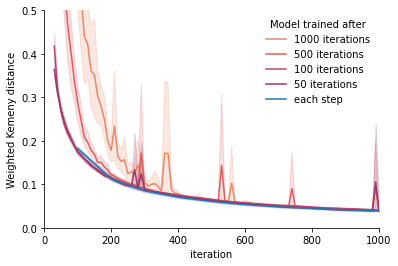

In [ ]:
std_palette = sns.color_palette()
palette = sns.color_palette('flare', 5)
palette[4] = std_palette[0]
ax = sns.lineplot(data, x='iteration', y='Weighted Kemeny distance', hue='Model trained after',
                  hue_order=['1000 iterations', '500 iterations', '100 iterations', '50 iterations', 'each step'], palette=palette)
ax.legend(title='Model trained after', frameon=False, prop={'size': 10})
ax.set(ylim=(0,0.5), xlim=(0,1000))
sns.despine()
ax.figure.savefig('generalizability_y5.png',dpi=600)

In [ ]:
data.loc[(data.iteration>300) & (data['Weighted Kemeny distance']>0.3)] #weird spikes

,trial,iteration,Weighted Kemeny distance,Model trained after,group
1379,4,990,0.563490,500 iterations,NaN
1576,5,990,0.702303,50 iterations,NaN
1629,5,530,0.880669,500 iterations,NaN
1650,5,740,0.469575,500 iterations,NaN
2027,6,560,0.489774,1000 iterations,NaN
2302,7,360,0.902188,1000 iterations,NaN
2600,8,370,0.800016,1000 iterations,NaN


## Full Accuracy Evaluation Using Generalizing Models

In [ ]:
tasks = list(product(range(10), [RankSampling], [False, True])) # trial, samplingMethod, apply_bias

if __name__ == '__main__':
    try: multiprocessing.set_start_method('spawn') # if it wasn't alrady set, make sure we use the `spawn` method.
    except RuntimeError: pass
    pool = multiprocessing.Pool(processes=10) # limit the num of processes in order to not overflow the GPU memory
    accuracy = pool.starmap(get_GNNRank_weightedTau, tasks)
    accuracy = [result for pool in accuracy for result in pool]
    accuracy = pd.DataFrame(accuracy, columns=['trial', 'iteration', 'value', 'bias_applied', 'sampling method', 'metric', 'group'])

In [ ]:
accuracy.to_csv('./data/GNNRank_results/samplingExperiments_rankSamplingCorrected.csv', index=False)

In [ ]:
accuracy

,trial,iteration,value,bias_applied,sampling method,metric,group
0,0,30,0.342773,False,RankSampling,tau,Overall
1,0,30,0.340037,False,RankSampling,tau,Privileged
2,0,30,0.344423,False,RankSampling,tau,Unprivileged
3,0,30,0.336593,False,RankSampling,tau,Privileged within-group
4,0,30,0.341486,False,RankSampling,tau,Between groups
...,...,...,...,...,...,...,...
15619,9,1000,0.058752,True,RankSampling,tau,Privileged within-group
15620,9,1000,0.392104,True,RankSampling,tau,Between groups
15621,9,1000,0.241750,True,RankSampling,tau,Unprivileged within-group
15622,9,1000,0.167743,True,RankSampling,exposure,Privileged


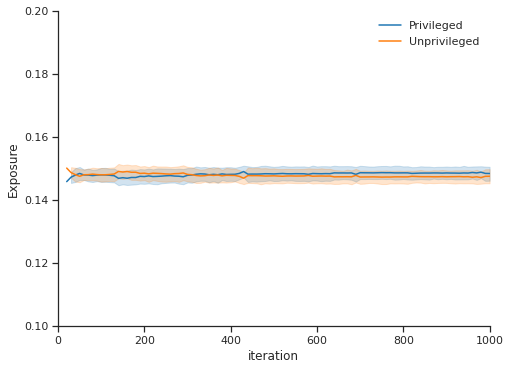

In [ ]:
df = accuracy.loc[(accuracy['sampling method'] == 'RankSampling') & (accuracy.metric == 'exposure') & (accuracy.bias_applied == False)].copy()

# remove outliers from bad generalization
for group in df.group.unique():
    df.loc[df.group == group, 'rolling'] = df.loc[df.group == group, 'value'].rolling(5, min_periods=1).mean()
df.loc[df.value > df['rolling'] + 0.1, 'value'] = None

df['Exposure'] = df.value

palette = sns.color_palette('tab10')
palette[2] = palette[7]
sns.set(rc={'figure.figsize':(4/3*5.8,5.8)})
sns.set_style('ticks')
with sns.color_palette(palette):
    ax = sns.lineplot(df, x='iteration', y='Exposure', hue='group', hue_order=['Privileged', 'Unprivileged'])
    #ax = sns.lineplot(df, x='iteration', y='Weighted Kemeny distance', hue='group', hue_order=['Privileged within-group', 'Unprivileged within-group', 'Between groups'])
ax.legend(title=None, frameon=False) #.remove()
ax.set(ylim=(0.1,0.2), xlim=(0,1000))
sns.despine()
plt.savefig('plots/GNNRank_exposure_noBias_rankSampling_10trials.png', dpi=150)

### Full Evaluation of the other Methods

In [ ]:
accuracy = pd.DataFrame()

In [ ]:
tasks = list(product(range(10), [RandomSampling, OversampleMinority, RankSampling],
                     [SVD_RS], [True, False])) #trial, samplingMethod, ranking_method, apply_bias

if __name__ == '__main__':
    pool = multiprocessing.Pool()
    accuracy_tmp = pool.starmap(get_method_accuracy, tasks)
    accuracy_tmp = [result for pool in accuracy_tmp for result in pool]
    accuracy_tmp = pd.DataFrame(accuracy_tmp, columns=['trial', 'iteration', 'value', 'bias_applied', 'sampling method', 'Ranking Method', 'metric', 'group'])

accuracy = accuracy_tmp
#accuracy = pd.concat([accuracy, accuracy_tmp], ignore_index=True).reset_index(drop=True)

In [ ]:
accuracy

,trial,iteration,value,bias_applied,sampling method,Ranking Method,metric,group
0,0,40,0.519428,True,RandomSampling,SVD_RS,tau,Overall
1,0,40,0.538814,True,RandomSampling,SVD_RS,tau,Privileged
2,0,40,0.519313,True,RandomSampling,SVD_RS,tau,Unprivileged
3,0,40,0.519822,True,RandomSampling,SVD_RS,tau,Privileged within-group
4,0,40,0.547130,True,RandomSampling,SVD_RS,tau,Between groups
...,...,...,...,...,...,...,...,...
142419,9,3000,0.123382,False,RankSampling,SVD_RS,tau,Privileged within-group
142420,9,3000,0.122697,False,RankSampling,SVD_RS,tau,Between groups
142421,9,3000,0.116647,False,RankSampling,SVD_RS,tau,Unprivileged within-group
142422,9,3000,0.148397,False,RankSampling,SVD_RS,exposure,Privileged


In [ ]:
accuracy.to_csv('./data/general_accuracy/generalAccuracy_SVD_RS_extended.csv', index=False)

### Plotting the combined Results

In [2]:
#acc_GNNRank = pd.read_csv('./data/general_accuracy/generalAccuracy_GNNRank.csv')
#acc_GNNRank = acc_GNNRank[acc_GNNRank['sampling method'] != 'RankSampling']
#acc_GNNRank = pd.concat([acc_GNNRank, pd.read_csv('./data/general_accuracy/generalAccuracy_GNNRank_rankSamplingCorrected.csv')], ignore_index=True)
#acc_GNNRank = acc_GNNRank.reset_index(drop=True)
acc_GNNRank = pd.read_csv('./data/general_accuracy/generalAccuracy_GNNRank_coarse_extended2.csv')
acc_GNNRank['Ranking Method'] = 'GNNRank'

acc_fairPR = pd.read_csv('./data/general_accuracy/generalAccuracy_fairPageRank_extended.csv')
acc_serialRank = pd.read_csv('./data/general_accuracy/generalAccuracy_serialRankv2_extended.csv')
acc_others = pd.read_csv('./data/general_accuracy/generalAccuracy_davidScore_rankCentrality_randomRecovery_extended.csv')
acc_btl = pd.read_csv('./data/general_accuracy/generalAccuracy_btl_extended.csv')
acc_eig = pd.read_csv('./data/general_accuracy/generalAccuracy_eigenvectorCentrality_extended.csv')
acc_PR = pd.read_csv('./data/general_accuracy/generalAccuracy_pageRank_extended.csv')
acc_SVD_NRS = pd.read_csv('./data/general_accuracy/generalAccuracy_SVD_NRS_extended.csv')
acc_SVD_RS = pd.read_csv('./data/general_accuracy/generalAccuracy_SVD_RS_extended.csv')
overall_acc = pd.concat([acc_GNNRank, acc_fairPR, acc_serialRank, acc_others, acc_btl, acc_eig, acc_PR, acc_SVD_NRS, acc_SVD_RS],
                        ignore_index=True).reset_index(drop=True)
overall_acc

,trial,iteration,value,bias_applied,sampling method,metric,group,Ranking Method
0,0,40,0.330061,False,RandomSampling,tau,Overall,GNNRank
1,0,40,0.340422,False,RandomSampling,tau,Privileged,GNNRank
2,0,40,0.322281,False,RandomSampling,tau,Unprivileged,GNNRank
3,0,40,0.357460,False,RandomSampling,tau,Privileged within-group,GNNRank
4,0,40,0.332949,False,RandomSampling,tau,Between groups,GNNRank
...,...,...,...,...,...,...,...,...
1495219,9,3000,0.123382,False,RankSampling,tau,Privileged within-group,SVD_RS
1495220,9,3000,0.122697,False,RankSampling,tau,Between groups,SVD_RS
1495221,9,3000,0.116647,False,RankSampling,tau,Unprivileged within-group,SVD_RS
1495222,9,3000,0.148397,False,RankSampling,exposure,Privileged,SVD_RS


In [17]:
palette = sns.color_palette('tab10')
#palette[0] = palette[7]
#palette[7] = palette[8]
#palette[8] = palette[9]
#palette = sns.color_palette('tab10', n_colors=11)
palette[0] = palette[1]
palette[1] = palette[2]
palette[2] = palette[3]
palette[3] = palette[4]
sns.set(rc={'figure.figsize':(4/3*5.8,5.8)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

for sampling_method in ['RandomSampling']:# overall_acc['sampling method'].unique():
    for bias in [False]: #overall_acc.bias_applied.unique():
        for ylim in [0.5]: #[0.5, 1]
            df = overall_acc.loc[(overall_acc['sampling method'] == sampling_method) & (overall_acc.bias_applied == bias)
                            & (overall_acc.metric == 'tau') & (overall_acc.group == 'Overall')].copy()
            
            # remove the GNNRank & the serialRank outliers
            #df.loc[df['Ranking Method'] == 'GNNRank', 'rolling'] = df.loc[df['Ranking Method'] == 'GNNRank', 'value'].rolling(5, min_periods=1).mean()
            #df.loc[df.value > df['rolling'] + 0.1, 'value'] = None
            #df.loc[df['Ranking Method'] == 'serialRank', 'rolling'] = df.loc[df['Ranking Method'] == 'serialRank', 'value'].rolling(5, min_periods=1).mean()
            #df.loc[df.value > df['rolling'] + 0.1, 'value'] = None

            # rename the value
            df['Weighted Kemeny distance'] = df.value
            # rename the ranking methods
            df.replace(['randomRankRecovery', 'davidScore', 'rankCentrality', 'fairPageRank', 'GNNRank', 'serialRank', 'btl', 'eigenvectorCentrality'],
                       ['Random Ranking', "David's Score", 'RankCentrality', 'Fairness-Aware PageRank', 'GNNRank', 'SerialRank', 'BTL', 'Eigenvector Centrality'],
                       inplace=True)

            if len(df) > 0:
                with sns.color_palette(palette):
                    ax = sns.lineplot(df, x='iteration', y='Weighted Kemeny distance', hue='Ranking Method',
                                      hue_order=["David's Score", 'RankCentrality', 'Fairness-Aware PageRank', 'GNNRank'])
                ax.get_legend().remove()
                #sns.move_legend(ax, "upper right", frameon=False)
                ax.set(xlim=(0,1000), ylim=(0,ylim), title='Oversample 75 %')
                sns.despine()
                plt.savefig(f'./plots/accuracyComparison_{sampling_method}_{"noBias" if not bias else ""}_y{int(ylim*10)}.png', dpi=150, bbox_inches="tight")
                plt.close()

### Individual Exposure/Kemeny distance plots

In [37]:
palette = sns.color_palette('tab10')
sns.set(rc={'figure.figsize':(4/3*5.8,5.8)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

for sampling_method in ['RandomSampling']:# overall_acc['sampling method'].unique():
    for bias in [True]: #overall_acc.bias_applied.unique():
        for ranking_method in ['rankCentrality']:
            df = overall_acc.loc[(overall_acc['sampling method'] == sampling_method) & (overall_acc.bias_applied == bias)
                            & (overall_acc.metric == 'tau') & (overall_acc['Ranking Method'] == ranking_method)].copy()

            # rename the value
            df['Weighted Kemeny distance'] = df.value

            if len(df) > 0:
                with sns.color_palette(palette):
                    ax = sns.lineplot(df, x='iteration', y='Weighted Kemeny distance', hue='group',
                                      hue_order=['Privileged', 'Unprivileged'])
                ax.get_legend().remove()
                #sns.move_legend(ax, "upper right", frameon=False)
                ax.set(xlim=(0,1000), ylim=(0,0.5), title='Random Sampling')
                sns.despine()
                plt.savefig(f'./plots/accuracy_{sampling_method}_{ranking_method}_{"noBias" if not bias else ""}_y{int(ylim*10)}.png', dpi=150, bbox_inches="tight")
                plt.close()

### Combined Exposure/Kemeny distance plots

In [ ]:
### Aggregate on ranking methods

for ranking_method in overall_acc['Ranking Method'].unique():
    for metric in overall_acc['metric'].unique():
        for bias in overall_acc['bias_applied'].unique():
            df = overall_acc.loc[(overall_acc['Ranking Method'] == ranking_method) & (overall_acc['iteration'] <= 1000)
                                 & (overall_acc['metric'] == metric) & (overall_acc['bias_applied'] == bias)].copy()
            
            # remove the GNNRank outliers
            if ranking_method == 'GNNRank':
                df['rolling'] = df['value'].rolling(5, min_periods=1).mean()
                df.loc[df.value > df['rolling'] + 0.1, 'value'] = None

            if metric == 'tau':
                renamed_metric = 'Weighted Kemeny Distance'
                ylim=(0, 0.5)
            else:
                renamed_metric = 'Exposure'
                ylim=(0.1, 0.2)
            df[renamed_metric] = df.value

            # Rename the Sampling Methods
            df.replace(['RandomSampling', 'OversampleMinority', 'RankSampling'],
                    ['Random Sampling', 'Oversampling 75 %', 'Rank-Based Sampling'], inplace=True)
            
            #df['With Bias'] = df['bias_applied']
            df['Sampling Method'] = df['sampling method']
            df['Group'] = df['group']

            with sns.color_palette('tab10'):
                ax = sns.lineplot(df, x='iteration', y=renamed_metric, hue='Sampling Method', style='Group',
                                  style_order=['Privileged', 'Unprivileged'],
                                  hue_order=['Random Sampling', 'Oversampling 75 %', 'Rank-Based Sampling'])
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
            ax.set(xlim=(0,1000), ylim=ylim)
            #ax.axhline(0, ls=':', c='black')
            sns.despine()
            plt.savefig(f'./plots/separate_{ranking_method}_{metric}_{"noBias" if not bias else "withBias"}.png', dpi=150, bbox_inches="tight")
            plt.close()

In [ ]:
### Aggregate on sampling methods
palette = sns.color_palette('tab10')
palette[0] = palette[2]
palette[1] = palette[3]
palette[2] = palette[4]

for sampling_method in overall_acc['sampling method'].unique():
    for metric in overall_acc['metric'].unique():
        for bias in overall_acc['bias_applied'].unique():
            df = overall_acc.loc[(overall_acc['sampling method'] == sampling_method) & (overall_acc['iteration'] <= 1000)
                                 & (overall_acc['metric'] == metric) & (overall_acc['bias_applied'] == bias)].copy()
            
            # remove the GNNRank outliers
            df.loc[df['Ranking Method'] == 'GNNRank', 'rolling'] = df.loc[df['Ranking Method'] == 'GNNRank', 'value'].rolling(5, min_periods=1).mean()
            df.loc[df.value > df['rolling'] + 0.1, 'value'] = None

            if metric == 'tau':
                renamed_metric = 'Weighted Kemeny Distance'
                ylim=(0, 0.5)
            else:
                renamed_metric = 'Exposure'
                ylim=(0.1, 0.2)
            df[renamed_metric] = df.value

            # Rename the Ranking Methods
            df.replace(['randomRankRecovery', 'davidScore', 'rankCentrality', 'fairPageRank', 'GNNRank'],
                   ['Random Ranking', "David's Score", 'Rank Centrality', 'Fairness-Aware PR', 'GNNRank'], inplace=True)
            
            df['Group'] = df['group']

            with sns.color_palette(palette):
                ax = sns.lineplot(df, x='iteration', y=renamed_metric, hue='Ranking Method', style='Group',
                                  style_order=['Privileged', 'Unprivileged'],
                                  hue_order=['Rank Centrality', 'Fairness-Aware PR', 'GNNRank'])
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
            ax.set(xlim=(0,1000), ylim=ylim)
            #ax.axhline(0, ls=':', c='black')
            sns.despine()
            plt.savefig(f'./plots/separate_{sampling_method}_{metric}_{"noBias" if not bias else "withBias"}.png', dpi=150, bbox_inches="tight")
            plt.close()

### Plotting Unprivileged-Privileged Diffferences

In [ ]:
_acc = pd.DataFrame()
for ranking_method in overall_acc['Ranking Method'].unique():
    for metric in overall_acc['metric'].unique():
        for sampling_method in overall_acc['sampling method'].unique():
            for bias in overall_acc.bias_applied.unique():
                for trial in overall_acc.trial.unique():
                    _priv_df = overall_acc.loc[(overall_acc['sampling method'] == sampling_method) & (overall_acc.bias_applied == bias)
                                              & (overall_acc.metric == metric) & (overall_acc['Ranking Method'] == ranking_method)
                                              & (overall_acc.group == 'Privileged') & (overall_acc.trial == trial)].copy().set_index('iteration')
                    _unpriv_df = overall_acc.loc[(overall_acc['sampling method'] == sampling_method) & (overall_acc.bias_applied == bias)
                                                & (overall_acc.metric == metric) & (overall_acc['Ranking Method'] == ranking_method)
                                                & (overall_acc.group == 'Unprivileged') & (overall_acc.trial == trial)].copy().set_index('iteration')
                    _unpriv_df['unpriv_value'] = _unpriv_df.value
                    _unpriv_df = _unpriv_df[['unpriv_value']]
                    _combined_df = pd.concat([_priv_df, _unpriv_df], axis=1)
                    _combined_df['value'] = _combined_df.unpriv_value - _combined_df.value
                    _combined_df = _combined_df.drop('unpriv_value', axis=1)
                    _combined_df['group'] = 'Difference'
                    _combined_df = _combined_df.reset_index()
                    _acc = pd.concat([_acc, _combined_df], ignore_index=True).reset_index(drop=True)
_acc

,iteration,trial,value,bias_applied,sampling method,metric,group,Ranking Method
0,30,0,-0.014786,False,RandomSampling,tau,Difference,GNNRank
1,40,0,-0.019766,False,RandomSampling,tau,Difference,GNNRank
2,50,0,-0.006181,False,RandomSampling,tau,Difference,GNNRank
3,60,0,-0.012101,False,RandomSampling,tau,Difference,GNNRank
4,70,0,-0.016553,False,RandomSampling,tau,Difference,GNNRank
...,...,...,...,...,...,...,...,...
58015,960,9,0.003567,True,RankSampling,exposure,Difference,randomRankRecovery
58016,970,9,0.002021,True,RankSampling,exposure,Difference,randomRankRecovery
58017,980,9,-0.000480,True,RankSampling,exposure,Difference,randomRankRecovery
58018,990,9,0.002054,True,RankSampling,exposure,Difference,randomRankRecovery


In [ ]:
### Aggregate on ranking methods

for ranking_method in _acc['Ranking Method'].unique():
    for metric in _acc['metric'].unique():
        df = _acc.loc[(_acc['Ranking Method'] == ranking_method) & (_acc['metric'] == metric)].copy()
        if metric == 'tau':
            diff_metric = 'Difference in Weighted Kemeny Distance'
            ylim=(-0.1, 0.1)
        else:
            diff_metric = 'Difference in Exposure'
            ylim=(-0.05, 0.05)
        df[diff_metric] = df.value

        # Rename the Sampling Methods
        df.replace(['RandomSampling', 'OversampleMinority', 'RankSampling'],
                   ['Random Sampling', 'Oversampling 75 %', 'Rank-Based Sampling'], inplace=True)
        
        df['With Bias'] = df['bias_applied']
        df['Sampling Method'] = df['sampling method']

        with sns.color_palette('tab10'):
            ax = sns.lineplot(df, x='iteration', y=diff_metric, hue='Sampling Method', style='With Bias',
                              hue_order=['Random Sampling', 'Oversampling 75 %', 'Rank-Based Sampling'])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
        ax.set(xlim=(0,1000), ylim=ylim)
        ax.axhline(0, ls=':', c='black')
        sns.despine()
        plt.savefig(f'./plots/differences_{ranking_method}_{metric}.png', dpi=150, bbox_inches="tight")
        plt.close()

In [ ]:
### Aggregate on sampling methods
palette = sns.color_palette('tab10')
palette[0] = palette[2]
palette[1] = palette[3]
palette[2] = palette[4]

for sampling_method in _acc['sampling method'].unique():
    for metric in _acc['metric'].unique():
        df = _acc.loc[(_acc['sampling method'] == sampling_method) & (_acc['metric'] == metric)].copy()
        if metric == 'tau':
            diff_metric = 'Difference in Weighted Kemeny Distance'
            ylim=(-0.1, 0.1)
        else:
            diff_metric = 'Difference in Exposure'
            ylim=(-0.05, 0.05)
        df[diff_metric] = df.value

        # Rename the Ranking Methods
        df.replace(['randomRankRecovery', 'davidScore', 'rankCentrality', 'fairPageRank', 'GNNRank'],
                   ['Random Ranking', "David's Score", 'Rank Centrality', 'Fairness-Aware PR', 'GNNRank'], inplace=True)
        
        df['With Bias'] = df['bias_applied']

        with sns.color_palette(palette):
            ax = sns.lineplot(df, x='iteration', y=diff_metric, hue='Ranking Method', style='With Bias',
                              hue_order=['Rank Centrality', 'Fairness-Aware PR', 'GNNRank'])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
        ax.set(xlim=(0,1000), ylim=ylim)
        ax.axhline(0, ls=':', c='black')
        sns.despine()
        plt.savefig(f'./plots/differences_{sampling_method}_{metric}.png', dpi=150, bbox_inches="tight")
        plt.close()

## Distribution of Scores in Rankings

In [ ]:
samplingMethod = RankSampling
trial = 0
apply_bias = False

# customize `dataset` to properly save the model
# get optimal settings from the paper: `baseline`, `pretrain_with`, `train_with`, `upset_margin_coeff`
# use defaults for: `early_stopping`, `epochs`
# handle output cleverly using: `load_only=True`, `regenerate_data=True`, `be_silent=True`
args = ArgsNamespace(AllTrain=True, ERO_style='uniform', F=70, Fiedler_layer_num=5, K=20, N=350, SavePred=False, all_methods=['DIGRAC', 'ib'],
                    alpha=1.0, baseline='syncRank', cuda=True, data_path='/home/jovyan/GNNRank/src/../data/',
                    dataset=f'fairPair_weightedTau/trial{trial}_{samplingMethod.__name__}_with{"out" if not apply_bias else ""}bias', be_silent=True,
                    debug=False, device=torch.device(type='cuda'), dropout=0.5, early_stopping=200, epochs=1000, eta=0.1, fill_val=0.5, hidden=8, hop=2,
                    load_only=True, log_root='/home/jovyan/GNNRank/src/../logs/', lr=0.01, no_cuda=False, num_trials=1, optimizer='Adam', p=0.05,
                    pretrain_epochs=50, pretrain_with='dist', regenerate_data=True, season=1990, seed=31, seeds=[10], sigma=1.0, tau=0.5, test_ratio=1,
                    train_ratio=1, train_with='proximal_baseline', trainable_alpha=False, upset_margin=0.01, upset_margin_coeff=0, upset_ratio_coeff=1.0, weight_decay=0.0005)
torch.manual_seed(args.seed)

# create an inital graph for training
H = FairPairGraph()
H.generate_groups(400, 200) # same size groups
H.assign_skills(loc=0, scale=0.86142674) # general skill distribution
if apply_bias:
    H.assign_bias(nodes=H.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

# do inital sampling
sampler = samplingMethod(H, warn=False)
while not nx.is_strongly_connected(H): # make sure it's a least strongly connected before we train GNNRank
    if samplingMethod.__name__ == 'OversampleMinority':
        sampler.apply(iter=50, k=1, p=0.75)
    elif samplingMethod.__name__ == 'RankSampling':
        ranker = RankRecovery(H)
        ranking, other_nodes = ranker.apply() # use default rankCentrality for pre-sampling
        sampler.apply(iter=50, k=1, ranking=ranking)
    else:
        sampler.apply(iter=50, k=1)
        
# train once on inital graph
adj = nx.linalg.graphmatrix.adjacency_matrix(H, weight='weight') # returns a sparse matrix
trainer = Trainer(args, random_seed=10, save_name_base='test', adj=adj) # initialize with the given adjacency matrix
save_path_best, save_path_latest = trainer.train(model_name='ib')

# create a new graph for inference
H = FairPairGraph()
H.generate_groups(400, 200) # same size groups
H.assign_skills(loc=0, scale=0.86142674) # general skill distribution
if apply_bias:
    H.assign_bias(nodes=H.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

sampler = samplingMethod(H, warn=False)
ranking = None
step = 10
# gradually infer ranking giving the initially trained model
for j in range(int(1000/step)):

    if samplingMethod.__name__ == 'OversampleMinority':
        sampler.apply(iter=step, k=1, p=0.75)
    elif samplingMethod.__name__ == 'RankSampling':
        sampler.apply(iter=step, k=1, ranking=ranking)
    else:
        sampler.apply(iter=step, k=1)
    
    if (nx.is_strongly_connected(H)):
        adj = nx.linalg.graphmatrix.adjacency_matrix(H, weight='weight') # returns a sparse matrix
        trainer = Trainer(args, random_seed=10, save_name_base='test', adj=adj) # initialize with the given adjacency matrix
        score, pred_label = trainer.predict_nn(model_name='ib', model_path=save_path_best, A=None, GNN_variant='proximal_baseline')
        ranking = {key: 1-score[0] for key, score in enumerate(score.cpu().detach().numpy())}
    
    if j%10 == 9:
        print(f'{samplingMethod.__name__}, with{"out" if not apply_bias else ""}bias, trial {trial}: finished {j*step+step} iterations.')

  0%|          | 0/1000 [00:00<?, ?epochs/s]

RankSampling, withoutbias, trial 0: finished 100 iterations.
RankSampling, withoutbias, trial 0: finished 200 iterations.
RankSampling, withoutbias, trial 0: finished 300 iterations.
RankSampling, withoutbias, trial 0: finished 400 iterations.
RankSampling, withoutbias, trial 0: finished 500 iterations.
RankSampling, withoutbias, trial 0: finished 600 iterations.
RankSampling, withoutbias, trial 0: finished 700 iterations.
RankSampling, withoutbias, trial 0: finished 800 iterations.
RankSampling, withoutbias, trial 0: finished 900 iterations.
RankSampling, withoutbias, trial 0: finished 1000 iterations.


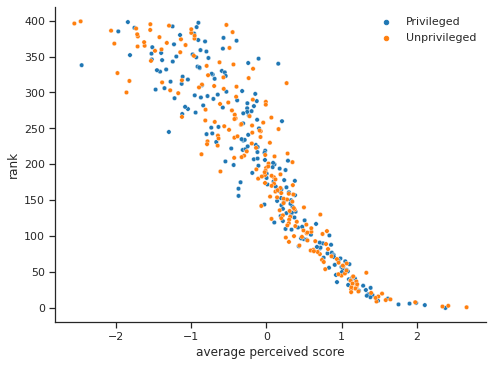

In [ ]:
ranks = []
j = 500

sns.set(rc={'figure.figsize':(4/3*5.8,5.8)})
sns.set_style('ticks')
for node, data in H.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Unprivileged' if data['minority'] else 'Privileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])
data = ranks
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
with sns.color_palette('tab10'):
    ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
#ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()
#plt.savefig('plots/GNNRank_rankSampling_comparisons_byScore_noBias.png', dpi=150)

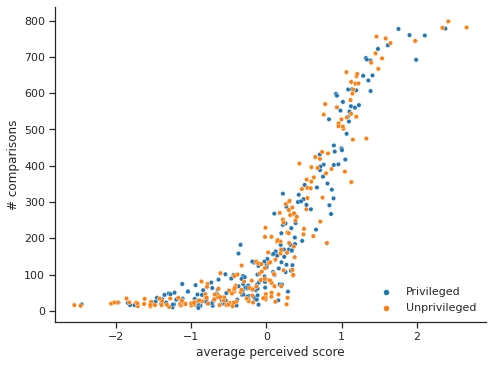

In [ ]:
ranks = []
j = 500
comparisons = {node:comp for node, comp in H.comparisons}

sns.set(rc={'figure.figsize':(4/3*5.8,5.8)})
sns.set_style('ticks')
for node, data in H.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], comparisons[node], 'Unprivileged' if data['minority'] else 'Privileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', '# comparisons', 'group'])
data = ranks
#data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
with sns.color_palette('tab10'):
    ax = sns.scatterplot(data, x='average perceived score', y='# comparisons', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='lower right')
#ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()
plt.savefig('plots/GNNRank_rankSampling_fixed_comparisons_byScore_noBias_iter1000.png', dpi=150)

### RankSampling with RankCentrality for Comparison

In [ ]:
# create a new graph for inference
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
#H.assign_bias(nodes=H.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

sampler = RankSampling(G, warn=False)
ranker = RankRecovery(G)
ranking2 = None
step = 10
connected = False
# gradually infer ranking giving the initially trained model
for j in range(int(1000/step)):
    sampler.apply(iter=step, k=1, ranking=ranking2)
    if (nx.is_strongly_connected(G)):
        if not connected:
            print(f'connected after {j*step} iterations')
            connected = True
        ranking2, other_nodes = ranker.apply()

connected after 20 iterations


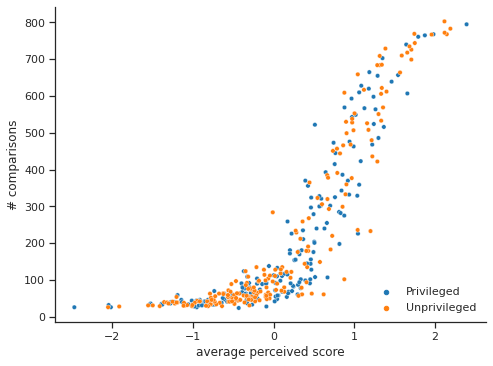

In [ ]:
ranks = []
j = 500
comparisons = {node:comp for node, comp in G.comparisons}
ranking2_ranks = scores_to_rank(ranking2)

sns.set(rc={'figure.figsize':(4/3*5.8,5.8)})
sns.set_style('ticks')
for node, data in G.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking2_ranks[node], comparisons[node], 'Unprivileged' if data['minority'] else 'Privileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', '# comparisons', 'group'])
data = ranks
#data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
with sns.color_palette('tab10'):
    ax = sns.scatterplot(data, x='average perceived score', y='# comparisons', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='lower right')
#ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()
plt.savefig('plots/RankCentrality_rankSampling_fixed_comparisons_byScore_noBias_1000iter.png', dpi=150)

### Distribution of scores in ranking

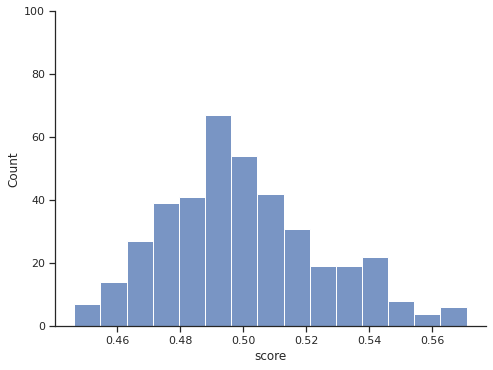

In [ ]:
ranking_list = ranking.values()
ranking_list = pd.DataFrame(ranking_list, columns=['score'])
ax = sns.histplot(data=ranking_list, x='score')
ax.set(ylim=(0,100))
sns.despine()

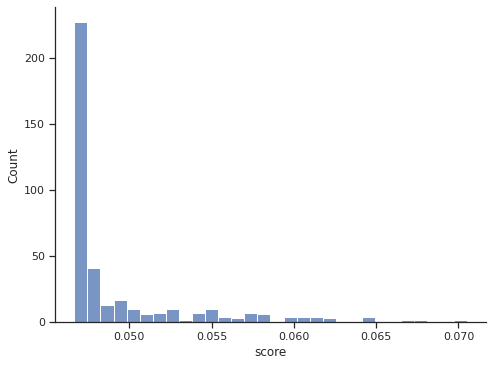

In [ ]:
ranking_list = ranking2.values()
ranking_list = pd.DataFrame(ranking_list, columns=['score'])
ax = sns.histplot(data=ranking_list, x='score')
#ax.set(ylim=(0,200))
sns.despine()

## GNN Rank Correlation Plots

In [ ]:
tasks = list(product([RandomSampling, OversampleMinority, RankSampling], [False, True])) # samplingMethod, apply_bias

if __name__ == '__main__':
    try: multiprocessing.set_start_method('spawn') # if it wasn't alrady set, make sure we use the `spawn` method.
    except RuntimeError: pass
    pool = multiprocessing.Pool(processes=10) # limit the num of processes in order to not overflow the GPU memory
    ranks = pool.starmap(get_GNNRank_correlations, tasks)
    ranks = [result for pool in ranks for result in pool]
    ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'average perceived score', 'rank', 'group', 'sampling method', 'bias_applied'])

In [ ]:
ranks.to_csv('./data/GNNRank_results/correlations.csv', index=False)

In [ ]:
df = ranks.loc[(ranks.iteration==1000) & (ranks['sampling method']=='RankSampling') & (ranks.bias_applied==True)]
df

,iteration,skill score,average perceived score,rank,group,sampling method,bias_applied
232000,1000,0.262491,0.262491,57,Privileged,RankSampling,True
232001,1000,-0.895870,-0.895870,193,Privileged,RankSampling,True
232002,1000,0.646459,0.646459,40,Privileged,RankSampling,True
232003,1000,0.810228,0.810228,25,Privileged,RankSampling,True
232004,1000,-1.680674,-1.680674,290,Privileged,RankSampling,True
...,...,...,...,...,...,...,...
232395,1000,0.119085,-1.702029,325,Unprivileged,RankSampling,True
232396,1000,0.654799,-0.503854,243,Unprivileged,RankSampling,True
232397,1000,0.197449,-1.408256,278,Unprivileged,RankSampling,True
232398,1000,0.456612,-0.981337,221,Unprivileged,RankSampling,True


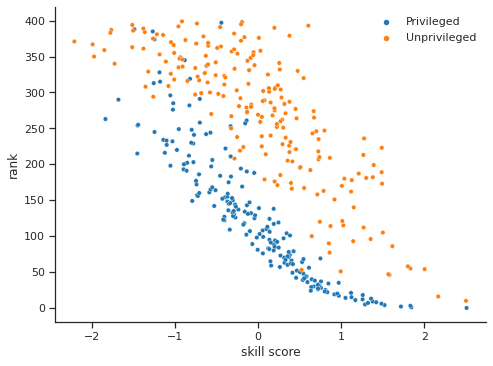

In [ ]:
sns.set(rc={'figure.figsize':(4/3*5.8,5.8)})
sns.set_style('ticks')
with sns.color_palette('tab10'):
    ax = sns.scatterplot(df, x='skill score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
sns.despine()